## NN5 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN5_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN5_Decile_Signal = pd.DataFrame(index=list_company)
df_NN5_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN5_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN5 model
    model_nn5 = Sequential()
    model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001), input_shape=(21,)))  # Input layer
    model_nn5.add(Dropout(0.4))
    model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 1
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 2
    model_nn5.add(Dropout(0.2))
    model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 3
    model_nn5.add(Dropout(0.5))
    model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.6))
    model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 5
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(1, activation='linear'))  # Output layer
    model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn5.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn5.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN5_Decile_Signal = df_NN5_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [39]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN5_Quintile_Signal = pd.concat([df_199804_199809, df_NN5_Quintile_Signal, df_202206], axis=1)
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.fillna(0).T
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.shift(1).dropna()

df_NN5_Decile_Signal = pd.concat([df_199804_199809, df_NN5_Decile_Signal, df_202206], axis=1)
df_NN5_Decile_Signal = df_NN5_Decile_Signal.fillna(0).T
df_NN5_Decile_Signal = df_NN5_Decile_Signal.shift(1).dropna()

df_NN5_20_Divided_Signal = pd.concat([df_199804_199809, df_NN5_20_Divided_Signal, df_202206], axis=1)
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.fillna(0).T
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.shift(1).dropna()

df_NN5_Percentile_Signal = pd.concat([df_199804_199809, df_NN5_Percentile_Signal, df_202206], axis=1)
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.fillna(0).T
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.shift(1).dropna()

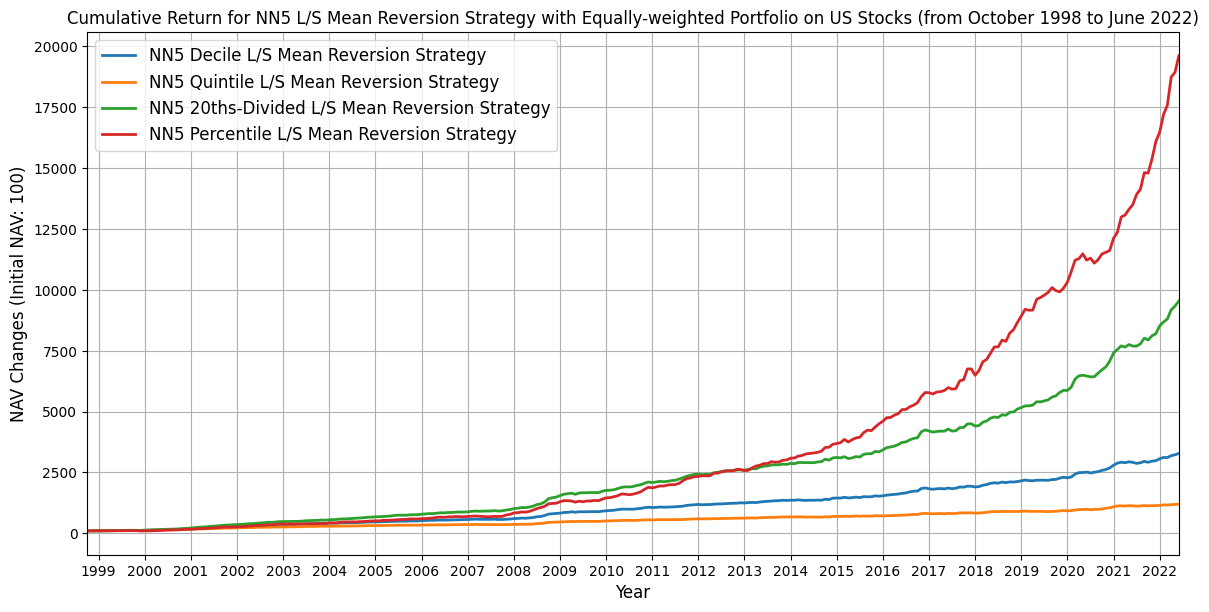

In [165]:
cum_NN5_Q_strategy_return = get_price_df(df_NN5_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_D_strategy_return = get_price_df(df_NN5_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_T_strategy_return = get_price_df(df_NN5_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_P_strategy_return = get_price_df(df_NN5_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN5_strategy_return = pd.concat([cum_NN5_D_strategy_return.rename('NN5 Decile L/S Mean Reversion Strategy'),
                                     cum_NN5_Q_strategy_return.rename('NN5 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN5_T_strategy_return.rename('NN5 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN5_P_strategy_return.rename('NN5 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN5_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN5 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [230]:
# Performance Stats
stats_NN5_Q = get_performance_stats(cum_NN5_Q_strategy_return, rfr=risk_free_rate_df, label='NN5 Quintile (Initial NAV: 100)')
stats_NN5_D = get_performance_stats(cum_NN5_D_strategy_return, rfr=risk_free_rate_df, label='NN5 Decile (Initial NAV: 100)')
stats_NN5_T = get_performance_stats(cum_NN5_T_strategy_return, rfr=risk_free_rate_df, label='NN5 20ths (Initial NAV: 100)')
stats_NN5_P = get_performance_stats(cum_NN5_P_strategy_return, rfr=risk_free_rate_df, label='NN5 Percentile (Initial NAV: 100)')
NN5_stats = pd.concat([stats_NN5_Q, stats_NN5_D, stats_NN5_T, stats_NN5_P], axis=0)
display(NN5_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN5 Quintile (Initial NAV: 100),11.249372,0.111259,0.018682,0.047883,1.933376,0.724075,0.742007,1224.937178,2022-06-30,0.023069,2019-02-28,2019-08-31,2019-11-30,275
NN5 Decile (Initial NAV: 100),33.355523,0.160576,0.018682,0.057318,2.475529,0.870641,1.639022,3435.552320,2022-06-30,0.024766,2021-05-31,2021-07-31,2021-09-30,122
NN5 20ths (Initial NAV: 100),103.512981,0.216236,0.018682,0.067420,2.930192,0.699165,1.496961,10451.298076,2022-06-30,0.032341,2016-12-31,2017-02-28,2017-06-30,181
NN5 Percentile (Initial NAV: 100),226.601904,0.256752,0.018682,0.087374,2.724709,0.121578,1.411404,22760.190381,2022-06-30,0.048935,2017-11-30,2018-01-31,2018-03-31,121


In [231]:
stats2_NN5_Q = get_performance_stats_2(df_NN5_Quintile_Signal, df_returns, df_market_cap, label='NN5 Quintile', model_type='ML')
stats2_NN5_D = get_performance_stats_2(df_NN5_Decile_Signal, df_returns, df_market_cap, label='NN5 Decile', model_type='ML')
stats2_NN5_T = get_performance_stats_2(df_NN5_20_Divided_Signal, df_returns, df_market_cap, label='NN5 20ths', model_type='ML')
stats2_NN5_P = get_performance_stats_2(df_NN5_Percentile_Signal, df_returns, df_market_cap, label='NN5 Percentile', model_type='ML')
NN5_stats2 = pd.concat([stats2_NN5_Q, stats2_NN5_D, stats2_NN5_T, stats2_NN5_P], axis=0)
display(NN5_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN5 Quintile (Long & Short),11.249372,0.008830,3.867094e+10,0.713793,0.090593,-0.075890,0.506355,0.521196,0.493866,270.717241
(Long Position),1234.259767,0.025294,5.682630e+08,0.696552,0.103169,-0.073704,0.568864,0.589249,0.551988,140.137931
(Short Position),-0.937405,-0.009676,7.380599e+10,0.379310,0.062310,-0.068434,0.449018,0.459824,0.439789,130.696552
NN5 Decile (Long & Short),33.355523,0.012487,6.726812e+10,0.772414,0.090633,-0.071061,0.519361,0.539189,0.502881,211.065517
(Long Position),9436.197076,0.032635,4.650007e+08,0.758621,0.103724,-0.064157,0.595940,0.628319,0.569836,110.982759
(Short Position),-0.934927,-0.009541,1.256990e+11,0.386207,0.061401,-0.067681,0.452807,0.464102,0.443167,100.093103
NN5 20ths (Long & Short),103.512981,0.016447,1.159337e+11,0.817241,0.091072,-0.066149,0.536517,0.562404,0.515274,147.765517
(Long Position),92779.255636,0.040950,4.482641e+08,0.844828,0.103764,-0.050836,0.641992,0.694277,0.601103,84.468966
(Short Position),-0.940053,-0.009826,2.094126e+11,0.400000,0.061652,-0.067844,0.451640,0.461229,0.443463,63.303448
NN5 Percentile (Long & Short),226.601904,0.019227,3.875807e+11,0.775862,0.089256,-0.069326,0.589778,0.605377,0.576559,47.386207


In [55]:
cum_NN5_Q_strategy_return_L = get_price_df(df_NN5_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_Q_strategy_return_S = get_price_df(df_NN5_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_L = get_price_df(df_NN5_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_S = get_price_df(df_NN5_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN5_Q_L = get_performance_stats(cum_NN5_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Quintile L (Initial NAV: 100)')
stats_NN5_Q_S = get_performance_stats(cum_NN5_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Quintile S (Initial NAV: 100)')
stats_NN5_D_L = get_performance_stats(cum_NN5_D_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Decile L (Initial NAV: 100)')
stats_NN5_D_S = get_performance_stats(cum_NN5_D_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Decile S (Initial NAV: 100)')
NN5_stats3 = pd.concat([stats_NN5_Q_L, stats_NN5_Q_S, stats_NN5_D_L, stats_NN5_D_S], axis=0)
display(NN5_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN5 Quintile L (Initial NAV: 100),1226.724568,0.349172,0.018682,0.168251,1.964266,0.363010,0.609937,139730.710008,2021-10-31,0.121364,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN5 Quintile S (Initial NAV: 100),7.628569,0.094984,0.018682,0.163599,0.466396,-0.561379,1.296159,1109.648153,2021-10-31,0.222405,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN5 Decile L (Initial NAV: 100),8855.006874,0.466221,0.018682,0.154783,2.891391,0.711811,1.266014,950094.228398,2022-03-31,0.067881,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN5 Decile S (Initial NAV: 100),6.839934,0.090574,0.018682,0.168064,0.427765,-0.480275,1.391595,1053.817951,2021-10-31,0.256045,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [ ]:
validation_date = ['1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [403]:
def creating_nn5(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn5 = kt.Hyperband(creating_nn5, objective='val_loss', max_epochs=50, project_name='nn5_tuning_1', overwrite=True)
tuner_nn5.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn5.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 4
lay1: 13
lay2: 19
lay3: 2
lay4: 16
lay5: 9
dropout1: 0.4
dropout2: 0.1
dropout3: 0.2
dropout4: 0.5
dropout5: 0.6
dropout6: 0.1
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 6
"""

### (3) Feature Importance

In [ ]:
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

nn5_importances_df = pd.DataFrame(index=feature_names)

for i in list_1:
    # Baseline NN4 model
    model_nn5 = Sequential()
    model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001), input_shape=(21,)))  # Input layer
    model_nn5.add(Dropout(0.4))
    model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 1
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 2
    model_nn5.add(Dropout(0.2))
    model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 3
    model_nn5.add(Dropout(0.5))
    model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.6))
    model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001)))  # hidden layer 5
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(1, activation='linear'))  # Output layer
    model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn5.fit(X_train, y_train)
    perm_nn5 = PermutationImportance(model_nn5, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
    nn5_importances_1 = pd.Series(perm_nn5.feature_importances_, index=feature_names)
    nn5_f = nn5_importances_1 / abs(nn5_importances_1).sum()
    nn5_importances_df = pd.concat([nn5_importances_df, nn5_f], axis=1)

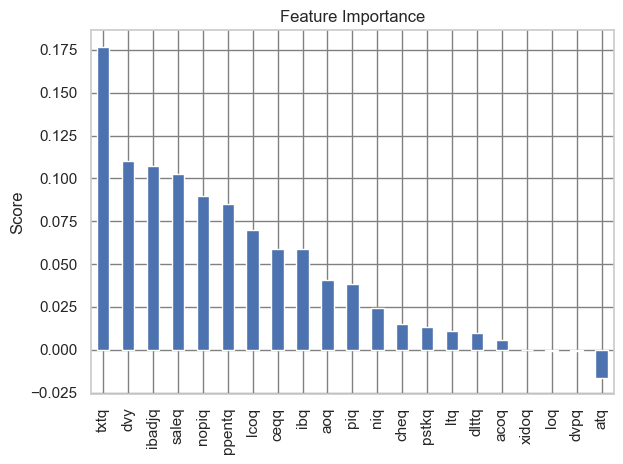

In [20]:
nn5_avg_importance = nn5_importances_df.mean(axis=1).sort_values(ascending=False)
fig, ax4 = plt.subplots()
nn5_avg_importance.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()